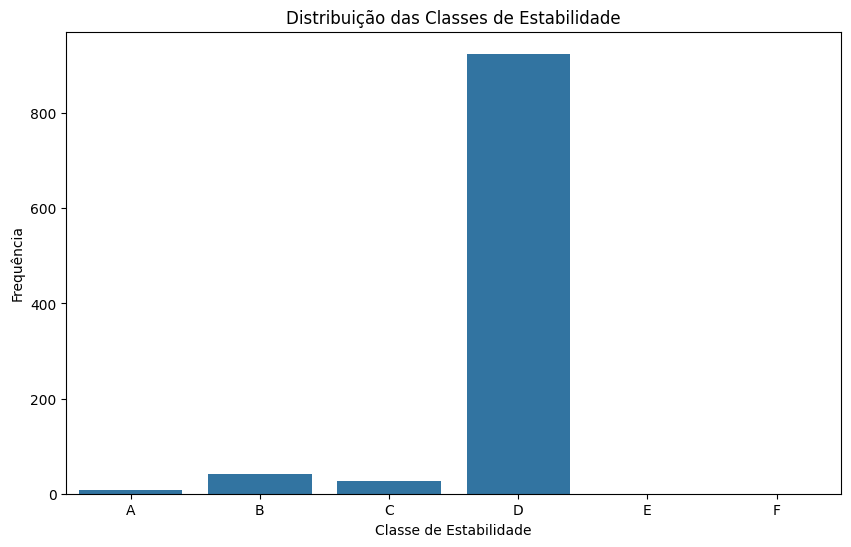

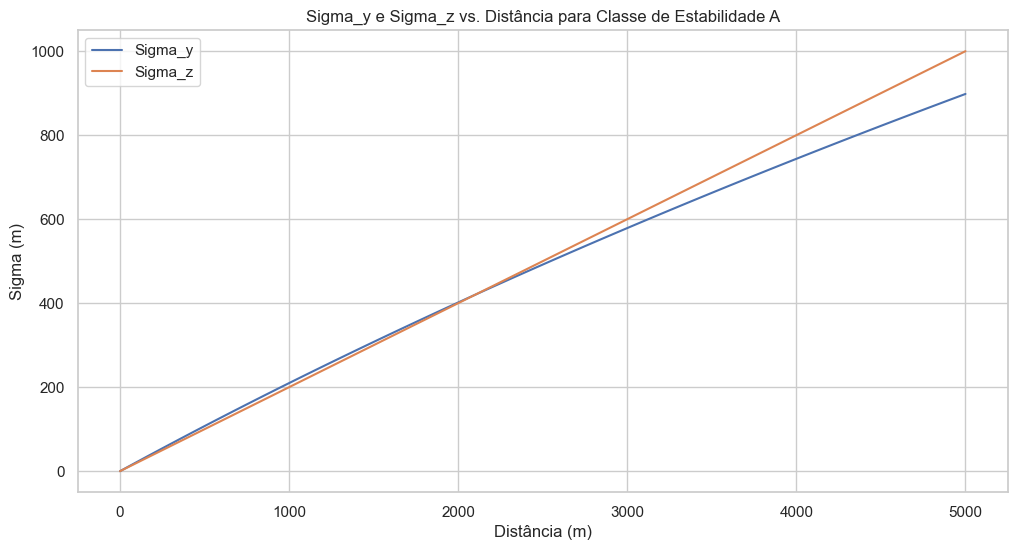

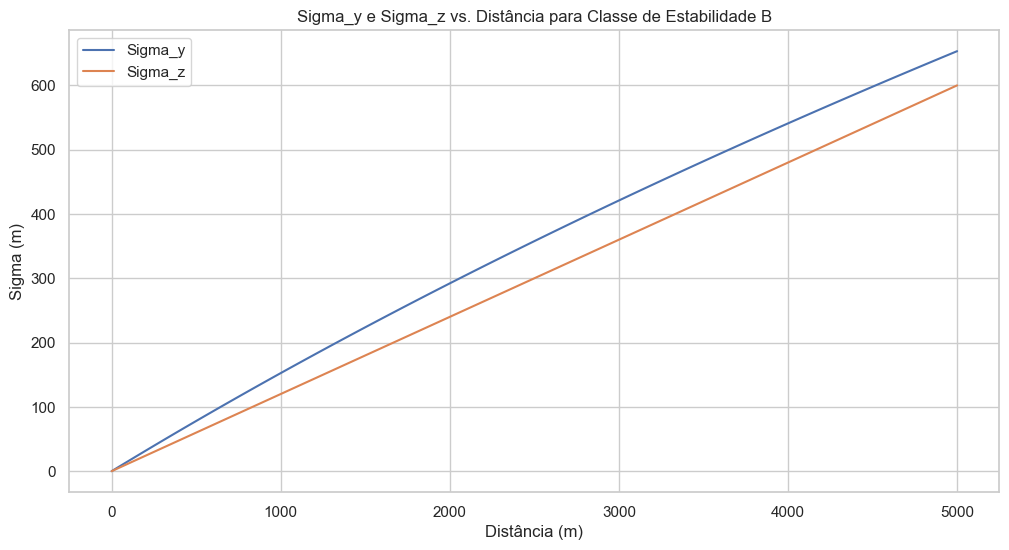

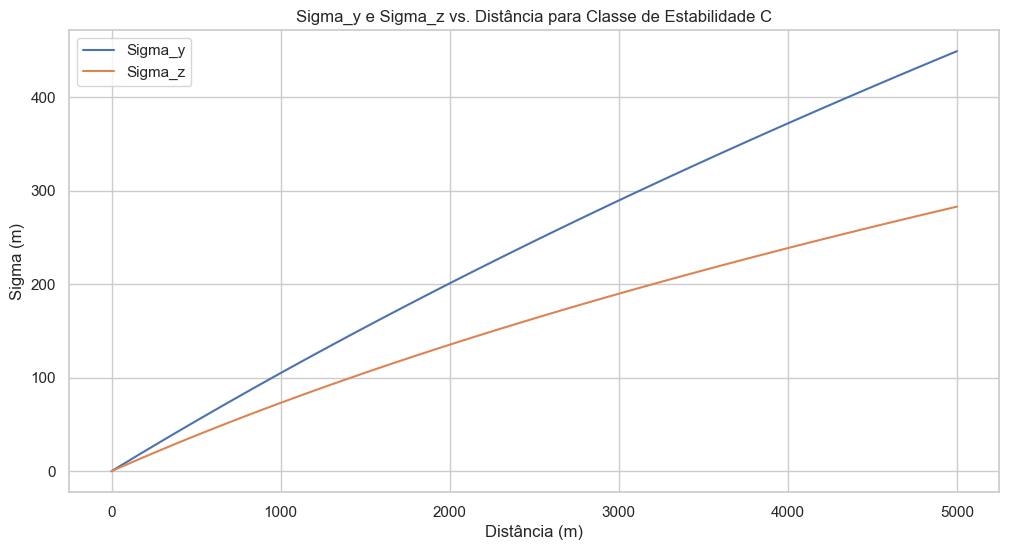

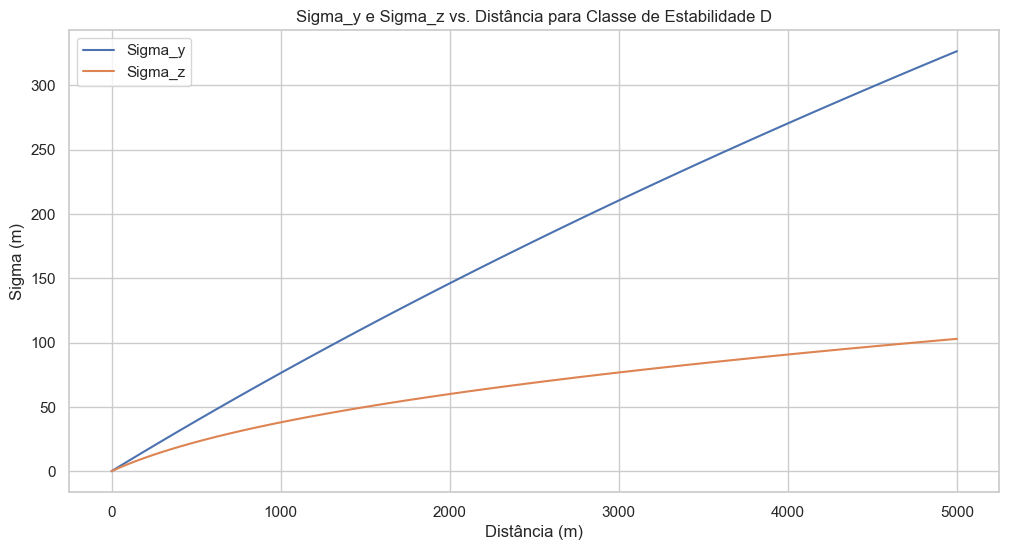

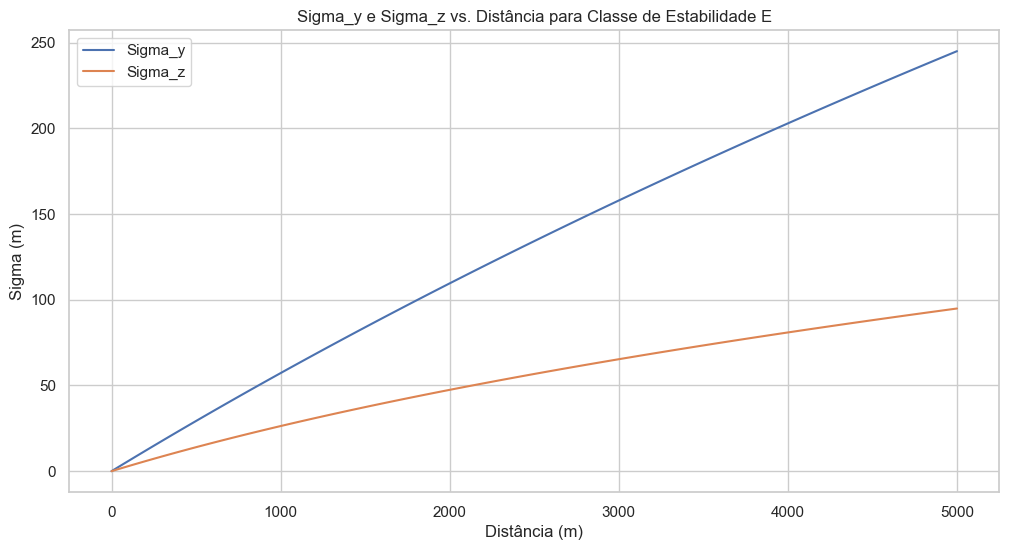

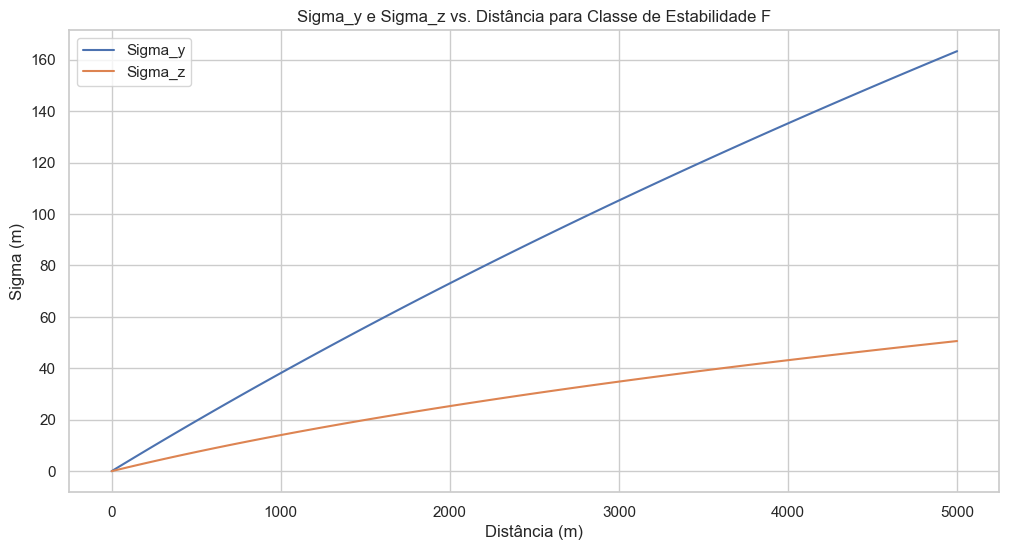

C:\Users\HP\AppData\Local\Temp\ipykernel_10500\3636025360.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  C = (Q / (2 * np.pi * u * sigma_y * sigma_z)) * \
C:\Users\HP\AppData\Local\Temp\ipykernel_10500\3636025360.py:82: RuntimeWarning: invalid value encountered in scalar divide
  np.exp(-y**2 / (2 * sigma_y**2)) * \
C:\Users\HP\AppData\Local\Temp\ipykernel_10500\3636025360.py:83: RuntimeWarning: divide by zero encountered in scalar divide
  (np.exp(-(z - H - delta_h)**2 / (2 * sigma_z**2)) + np.exp(-(z + H + delta_h)**2 / (2 * sigma_z**2)))


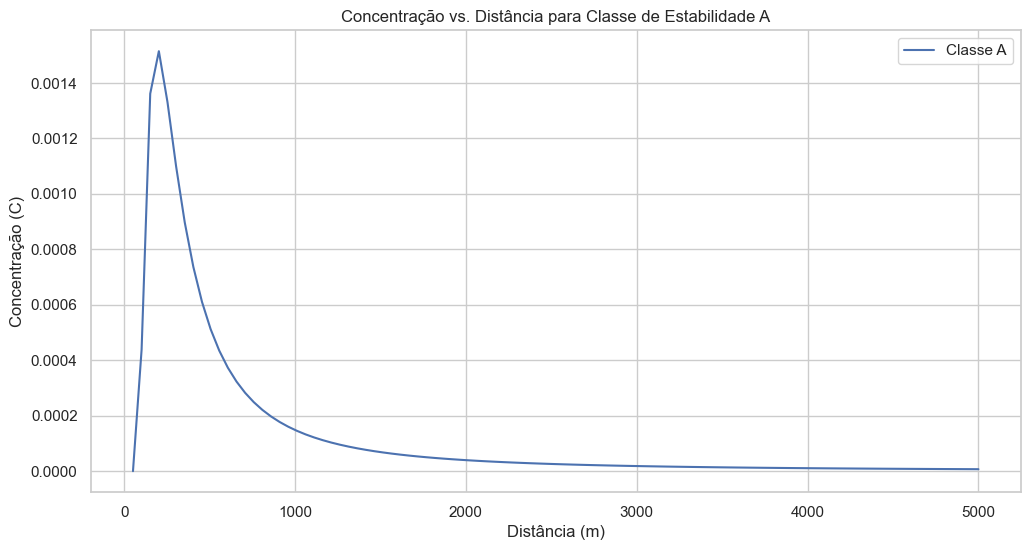

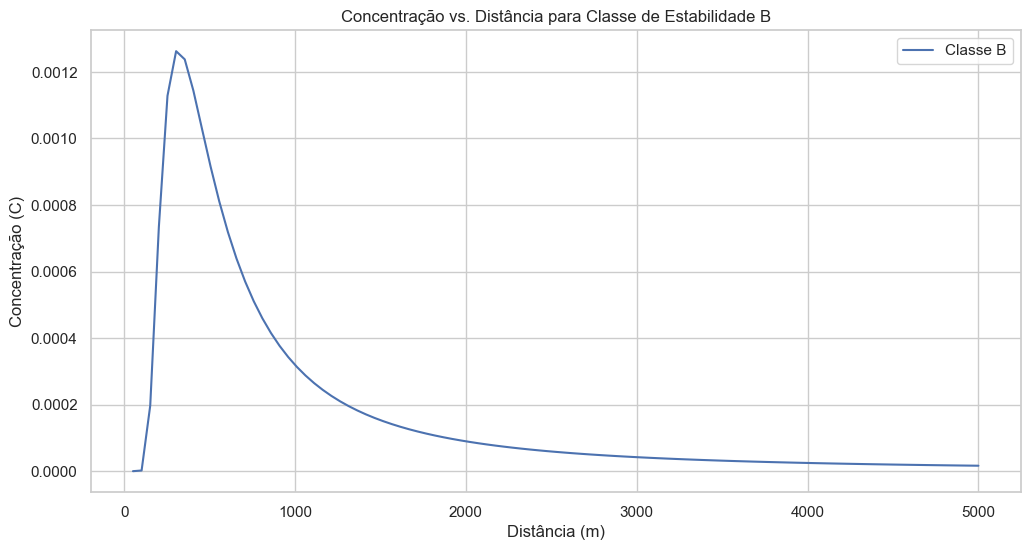

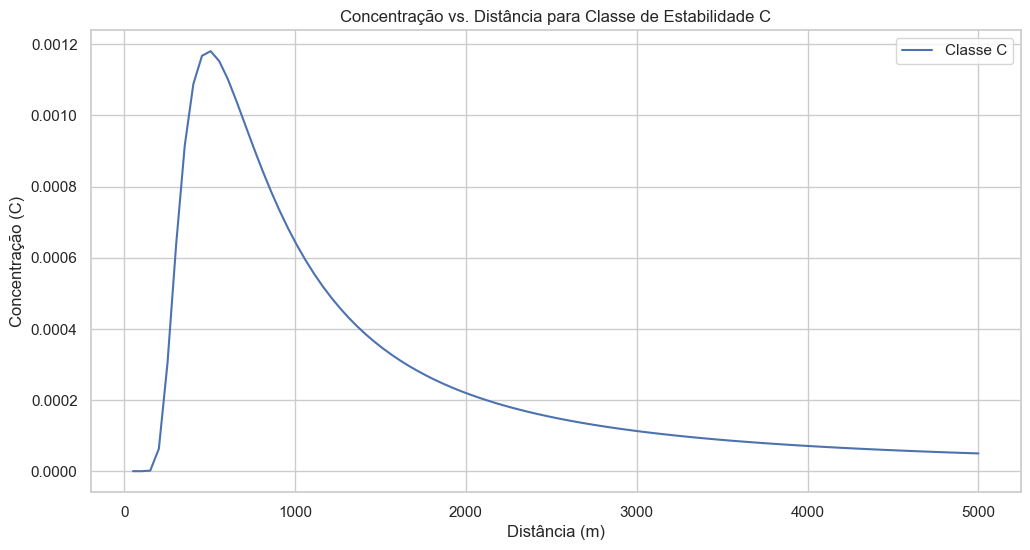

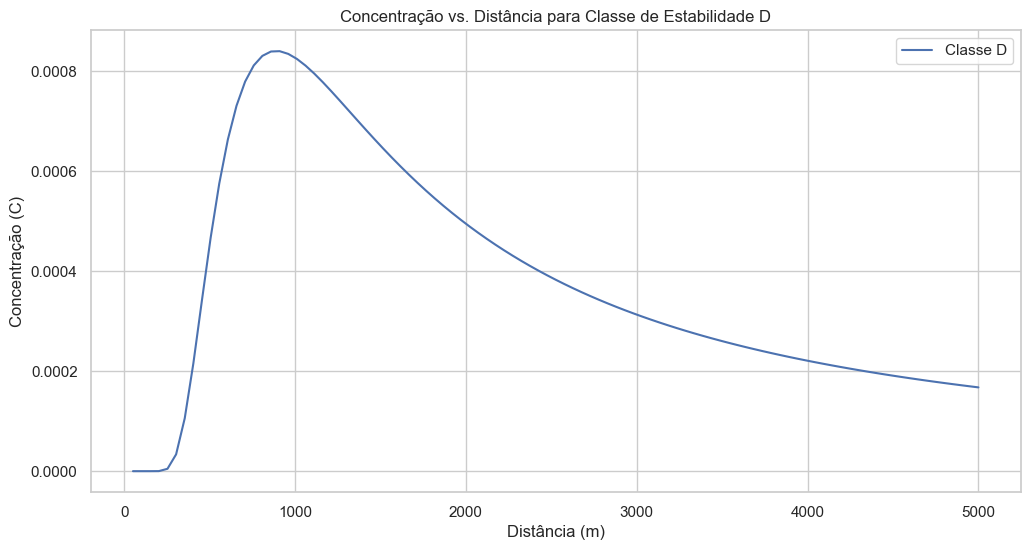

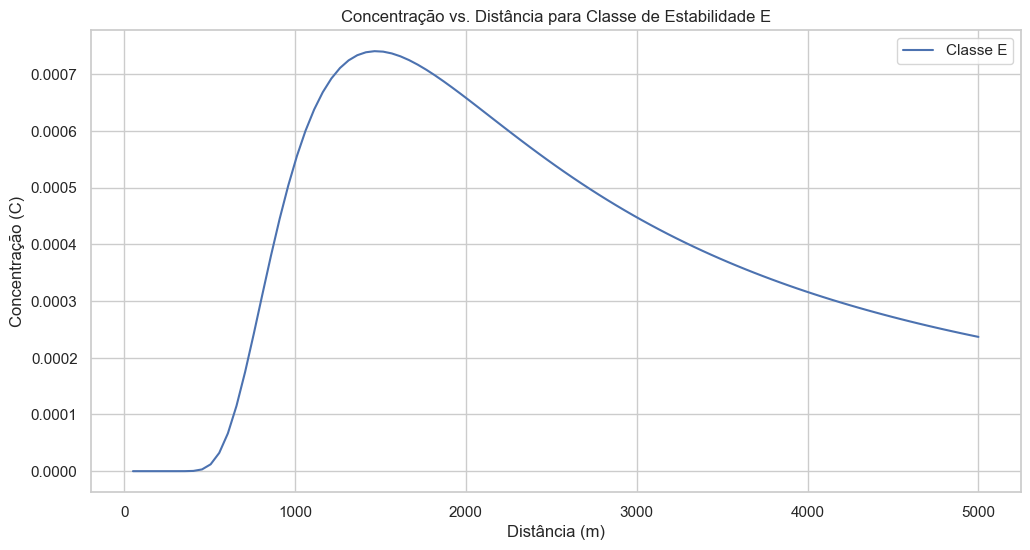

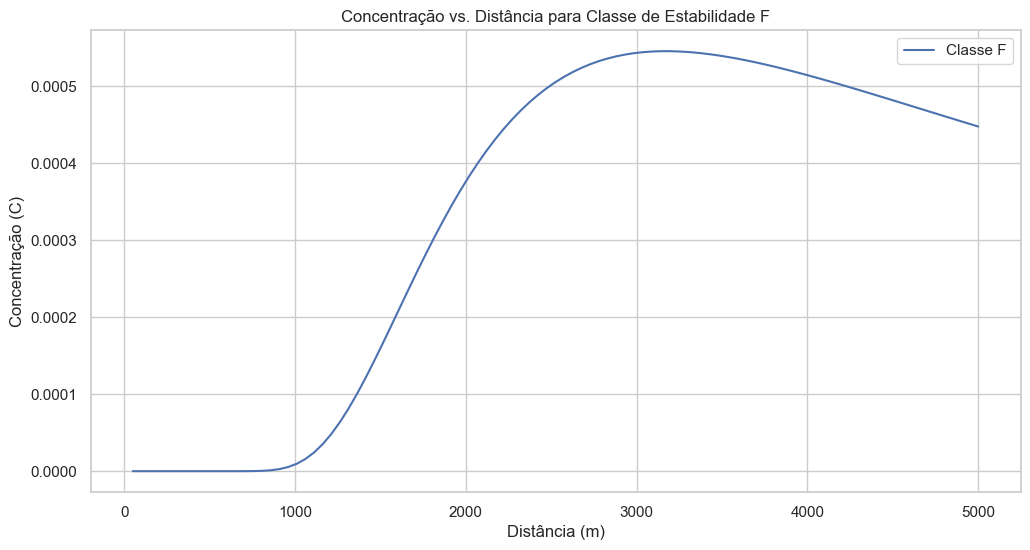

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Função para determinar a classe de estabilidade de Pasquil considerando radiação solar
def determinar_classe_de_estabilidade(velocidade_vento, cobertura_nuvens, temp, radiacao_solar):
    if temp >= 600:
        if velocidade_vento < 2 and radiacao_solar >= 200:
            return 'A'
        elif 2 <= velocidade_vento < 3 and radiacao_solar >= 200:
            return 'B'
        elif 3 <= velocidade_vento < 5 and radiacao_solar >= 200:
            return 'C'
        else:
            return 'D'
    elif 300 <= temp < 600:
        if velocidade_vento < 2 and radiacao_solar >= 200:
            return 'B'
        elif 2 <= velocidade_vento < 3 and radiacao_solar >= 200:
            return 'B'
        elif 3 <= velocidade_vento < 5 and radiacao_solar >= 200:
            return 'C'
        else:
            return 'D'
    elif temp < 300:
        if velocidade_vento < 2 and radiacao_solar >= 200:
            return 'C'
        elif 2 <= velocidade_vento < 3 and radiacao_solar >= 200:
            return 'C'
        elif 3 <= velocidade_vento < 5 and radiacao_solar >= 200:
            return 'D'
        else:
            return 'D'
    elif cobertura_nuvens > 4:
        if velocidade_vento < 2 and radiacao_solar >= 200:
            return 'E'
        else:
            return 'F'
    else:
        return 'D'

# Função para calcular sigma_y
def calcular_sigma_y(x, classe_estabilidade):
    if classe_estabilidade == 'A':
        return 0.22 * x * (1 + 0.0001 * x)**(-0.5)
    elif classe_estabilidade == 'B':
        return 0.16 * x * (1 + 0.0001 * x)**(-0.5)
    elif classe_estabilidade == 'C':
        return 0.11 * x * (1 + 0.0001 * x)**(-0.5)
    elif classe_estabilidade == 'D':
        return 0.08 * x * (1 + 0.0001 * x)**(-0.5)
    elif classe_estabilidade == 'E':
        return 0.06 * x * (1 + 0.0001 * x)**(-0.5)
    elif classe_estabilidade == 'F':
        return 0.04 * x * (1 + 0.0001 * x)**(-0.5)

# Função para calcular sigma_z
def calcular_sigma_z(x, classe_estabilidade):
    if classe_estabilidade == 'A':
        return 0.20 * x
    elif classe_estabilidade == 'B':
        return 0.12 * x
    elif classe_estabilidade == 'C':
        return 0.08 * x * (1 + 0.0002 * x)**(-0.5)
    elif classe_estabilidade == 'D':
        return 0.06 * x * (1 + 0.0015 * x)**(-0.5)
    elif classe_estabilidade == 'E':
        return 0.03 * x * (1 + 0.0003 * x)**(-0.5)
    elif classe_estabilidade == 'F':
        return 0.016 * x * (1 + 0.0003 * x)**(-0.5)

# Função para estimar a sobrelevação da pluma pelo método de Briggs
def calcular_sobrelevação_pluma_briggs(Q, D, u):
    F = (1.5 * Q) / (np.pi * D**2 * u)
    return 1.6 * F**(1/3) * D**(2/3)

# Função do modelo gaussiano
def modelo_gaussiano(Q, u, x, y, z, H, sigma_y, sigma_z, delta_h):
    C = (Q / (2 * np.pi * u * sigma_y * sigma_z)) * \
        np.exp(-y**2 / (2 * sigma_y**2)) * \
        (np.exp(-(z - H - delta_h)**2 / (2 * sigma_z**2)) + np.exp(-(z + H + delta_h)**2 / (2 * sigma_z**2)))
    return C

# Carregar dados de calor sensível
caminho_arquivo = 'C:\\Users\\HP\\Documents\\Gabriel.py\\ENS5173\\dados brutos\\METEO\\METEO.csv'

meteo_data = pd.read_csv(caminho_arquivo)

# Calcular média e desvio padrão do calor sensível (sensible heat flux)
mu_calor_sensivel = meteo_data['sensible heat flux (W/m^2)'].mean()
sigma_calor_sensivel = meteo_data['sensible heat flux (W/m^2)'].std()

# Definindo os parâmetros do método de Monte Carlo para radiação solar
n_amostras = 1000  # número de amostras a serem geradas

# Gerando valores aleatórios para radiação solar usando Monte Carlo com base no calor sensível
radiacao_solar = np.random.normal(mu_calor_sensivel, sigma_calor_sensivel, n_amostras)

# Criando DataFrame de exemplo
data = {
    'ws': np.random.uniform(0, 10, n_amostras),  # velocidade do vento
    'cco': np.random.uniform(0, 8, n_amostras),  # cobertura de nuvens
    'temp': np.random.uniform(200, 700, n_amostras),  # temperatura
    'Radiacao_Solar': radiacao_solar
}
metSuperficie = pd.DataFrame(data)

# Adicionar a coluna de classe de estabilidade aos dados
metSuperficie['Classe_Estabilidade'] = metSuperficie.apply(
    lambda row: determinar_classe_de_estabilidade(row['ws'], row['cco'], row['temp'], row['Radiacao_Solar']),
    axis=1
)

# Calcular sigma_y e sigma_z para os dados
x = 1000  # Exemplo de distância
metSuperficie['Sigma_y'] = metSuperficie.apply(lambda row: calcular_sigma_y(x, row['Classe_Estabilidade']), axis=1)
metSuperficie['Sigma_z'] = metSuperficie.apply(lambda row: calcular_sigma_z(x, row['Classe_Estabilidade']), axis=1)

# Parâmetros de exemplo
Q = 100  # Taxa de emissão
D = 10   # Diâmetro da chaminé
u = metSuperficie['ws'].mean()  # Média da velocidade do vento nos dados

# Calcular a sobrelevação da pluma
metSuperficie['Delta_h'] = calcular_sobrelevação_pluma_briggs(Q, D, u)

# Aplicar o modelo gaussiano aos dados
H = 50  # Altura da chaminé
y = 0
z = 0

metSuperficie['Concentracao'] = metSuperficie.apply(
    lambda row: modelo_gaussiano(Q, u, x, y, z, H, row['Sigma_y'], row['Sigma_z'], row['Delta_h']),
    axis=1
)

# Plotar a distribuição das classes de estabilidade
plt.figure(figsize=(10, 6))
sns.countplot(data=metSuperficie, x='Classe_Estabilidade', order=['A', 'B', 'C', 'D', 'E', 'F'])
plt.title('Distribuição das Classes de Estabilidade')
plt.xlabel('Classe de Estabilidade')
plt.ylabel('Frequência')
plt.show()

# Configurando o estilo dos gráficos
sns.set(style="whitegrid")

# Considerando um intervalo de distâncias para calcular sigma_y e sigma_z
distancias = np.linspace(0, 5000, 100)

# Função para plotar sigma_y e sigma_z
def plotar_sigma(classe_estabilidade, distancias):
    sigma_y_values = [calcular_sigma_y(d, classe_estabilidade) for d in distancias]
    sigma_z_values = [calcular_sigma_z(d, classe_estabilidade) for d in distancias]
    
    plt.figure(figsize=(12, 6))
    plt.plot(distancias, sigma_y_values, label='Sigma_y')
    plt.plot(distancias, sigma_z_values, label='Sigma_z')
    plt.title(f'Sigma_y e Sigma_z vs. Distância para Classe de Estabilidade {classe_estabilidade}')
    plt.xlabel('Distância (m)')
    plt.ylabel('Sigma (m)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ordenar as classes de estabilidade conforme 'A', 'B', 'C', 'D', 'E', 'F'
classes_estabilidade = ['A', 'B', 'C', 'D', 'E', 'F']

# Plotar para cada classe de estabilidade na ordem especificada
for classe in classes_estabilidade:
    plotar_sigma(classe, distancias)

# Função para plotar concentração em função da distância
def plotar_concentracao(classe_estabilidade, distancias, Q, u, y, z, H):
    sigma_y_values = [calcular_sigma_y(d, classe_estabilidade) for d in distancias]
    sigma_z_values = [calcular_sigma_z(d, classe_estabilidade) for d in distancias]
    delta_h = calcular_sobrelevação_pluma_briggs(Q, D, u)
    
    concentracoes = [modelo_gaussiano(Q, u, d, y, z, H, sigma_y, sigma_z, delta_h)
                     for d, sigma_y, sigma_z in zip(distancias, sigma_y_values, sigma_z_values)]
    
    plt.figure(figsize=(12, 6))
    plt.plot(distancias, concentracoes, label=f'Classe {classe_estabilidade}')
    plt.title(f'Concentração vs. Distância para Classe de Estabilidade {classe_estabilidade}')
    plt.xlabel('Distância (m)')
    plt.ylabel('Concentração (C)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotar para cada classe de estabilidade na ordem especificada
for classe in classes_estabilidade:
    plotar_concentracao(classe, distancias, Q, u, y, z, H)



Classe de estabilidade de Pasquill: C
Sobrelevação da pluma (deltaH): 0.16145863010432795
Altura efetiva da chaminé (H_eff): 288.16145863010433


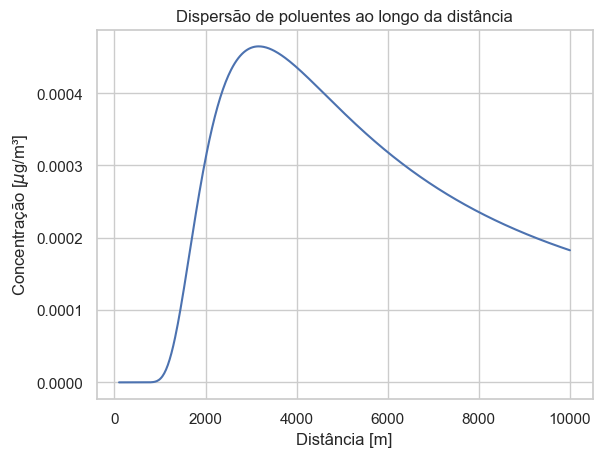

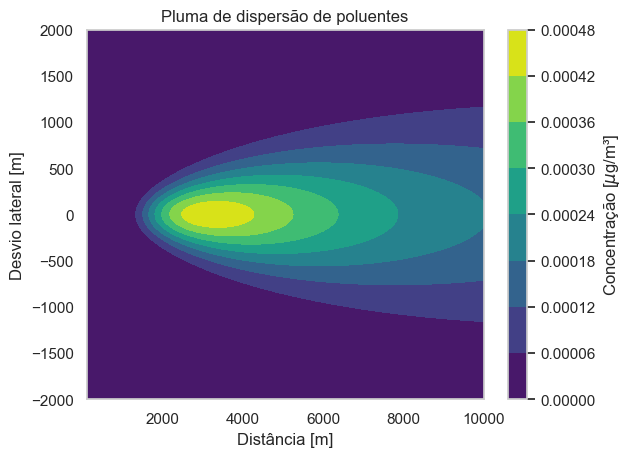

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Funções auxiliares
def sigmaYZ(x, classe_estabilidade, urbOrRural):
    if urbOrRural == 'urbano':
        if classe_estabilidade == 'A':
            sigma_y = 0.22 * x * (1 + 0.0001 * x)**-0.5
            sigma_z = 0.2 * x
        elif classe_estabilidade == 'B':
            sigma_y = 0.16 * x * (1 + 0.0001 * x)**-0.5
            sigma_z = 0.12 * x
        elif classe_estabilidade == 'C':
            sigma_y = 0.11 * x * (1 + 0.0001 * x)**-0.5
            sigma_z = 0.08 * x * (1 + 0.0002 * x)**-0.5
        elif classe_estabilidade == 'D':
            sigma_y = 0.08 * x * (1 + 0.0001 * x)**-0.5
            sigma_z = 0.06 * x * (1 + 0.0015 * x)**-0.5
        elif classe_estabilidade == 'E':
            sigma_y = 0.06 * x * (1 + 0.0001 * x)**-0.5
            sigma_z = 0.03 * x * (1 + 0.0003 * x)**-0.5
        elif classe_estabilidade == 'F':
            sigma_y = 0.04 * x * (1 + 0.0001 * x)**-0.5
            sigma_z = 0.016 * x * (1 + 0.0003 * x)**-0.5
    else:
        # Implementação para rural (se necessário)
        pass
    return sigma_y, sigma_z

def sobrelevacaoBriggs(Fb, Vs, d, u, deltaT, Ts, H, tipo_atmosfera):
    if tipo_atmosfera == 'quente':
        deltaH = (1.5 * Fb**0.333) / (Vs * u**0.666)
    else:
        deltaH = (2.0 * Fb**0.333) / (Vs * u**0.666)
    return deltaH

def modeloGaussiano(qs, sigma_y, sigma_z, u, y, z, H_eff):
    return (qs / (2 * np.pi * u * sigma_y * sigma_z)) * \
           np.exp(-y**2 / (2 * sigma_y**2)) * \
           np.exp(-(z - H_eff)**2 / (2 * sigma_z**2))

# Parâmetros de entrada
qs = 5000  # g/s
u = 10  # m/s
y = 0  # estimando na direção do vento
z = 1.5  # altura do nariz
H = 288  # m
urbOrRural = 'urbano'
x = np.linspace(100, 10000, 500)  # Distâncias de 100 a 10000 m

# Parâmetros adicionais
d = 2.5  # Diâmetro interno da chaminé em metros (exemplo)
Vs = 20  # Velocidade do efluente na saída da chaminé em m/s (exemplo)
p = 1013  # Pressão atmosférica em milibares (exemplo)
deltaT = 60  # Diferença de temperatura entre o gás na chaminé e a temperatura ambiente em K (exemplo)
Ts = 533  # Temperatura do gás na saída da chaminé em K (exemplo)
Fb = 1000  # Parâmetro de empuxo (exemplo)
tipo_atmosfera = 'quente'  # ou 'frio'

# Selecionar aleatoriamente um dia específico para a simulação (apenas exemplo, substitua pela lógica real)
classe = 'C'  # Classe de estabilidade exemplo
velocidade_vento = u  # Usando a velocidade do vento de entrada

# Determinação da classe de estabilidade
print("Classe de estabilidade de Pasquill:", classe)

# Estimativa dos coeficientes de dispersão
sigmaY, sigmaZ = sigmaYZ(x, classe, urbOrRural)

# Estimativa da sobrelevação da pluma usando o modelo de Briggs
deltaH = sobrelevacaoBriggs(Fb, Vs, d, u, deltaT, Ts, H, tipo_atmosfera)
H_eff = H + deltaH
print("Sobrelevação da pluma (deltaH):", deltaH)
print("Altura efetiva da chaminé (H_eff):", H_eff)

# Cálculo da concentração de poluentes
conc = modeloGaussiano(qs, sigmaY, sigmaZ, u, y, z, H_eff)

# Visualização dos resultados
plt.plot(x, conc)
plt.xlabel('Distância [m]')
plt.ylabel('Concentração [$\mu$g/m³]')
plt.title('Dispersão de poluentes ao longo da distância')
plt.show()

# Visualização dos resultados no espaço (pluma de dispersão)
X, Y = np.meshgrid(x, np.linspace(-2000, 2000, 500))  # Ajuste do desvio lateral
sigmaY, sigmaZ = sigmaYZ(X, classe, urbOrRural)
conc2D = modeloGaussiano(qs, sigmaY, sigmaZ, u, Y, z, H_eff)

fig, ax = plt.subplots()
contour = ax.contourf(X, Y, conc2D, cmap='viridis')
plt.colorbar(contour, label='Concentração [$\mu$g/m³]')
plt.xlabel('Distância [m]')
plt.ylabel('Desvio lateral [m]')
plt.title('Pluma de dispersão de poluentes')
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_10500\3636025360.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  C = (Q / (2 * np.pi * u * sigma_y * sigma_z)) * \
C:\Users\HP\AppData\Local\Temp\ipykernel_10500\3636025360.py:82: RuntimeWarning: invalid value encountered in scalar divide
  np.exp(-y**2 / (2 * sigma_y**2)) * \
C:\Users\HP\AppData\Local\Temp\ipykernel_10500\3636025360.py:83: RuntimeWarning: divide by zero encountered in scalar divide
  (np.exp(-(z - H - delta_h)**2 / (2 * sigma_z**2)) + np.exp(-(z + H + delta_h)**2 / (2 * sigma_z**2)))


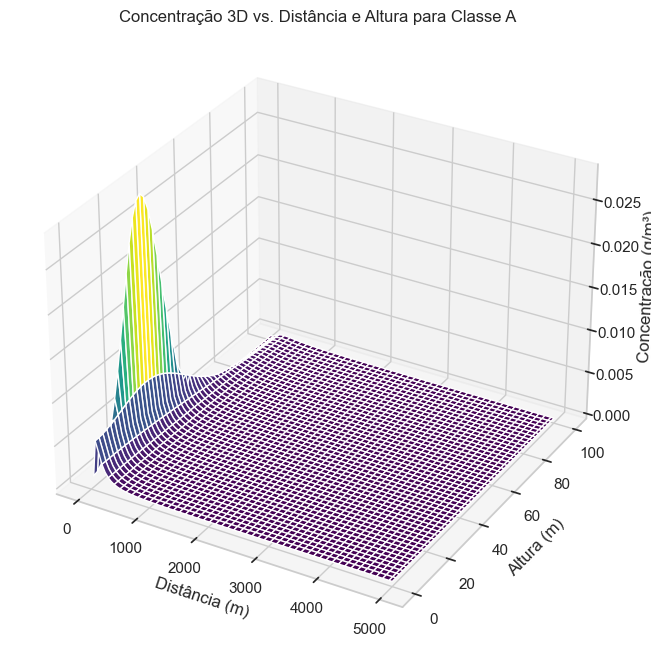

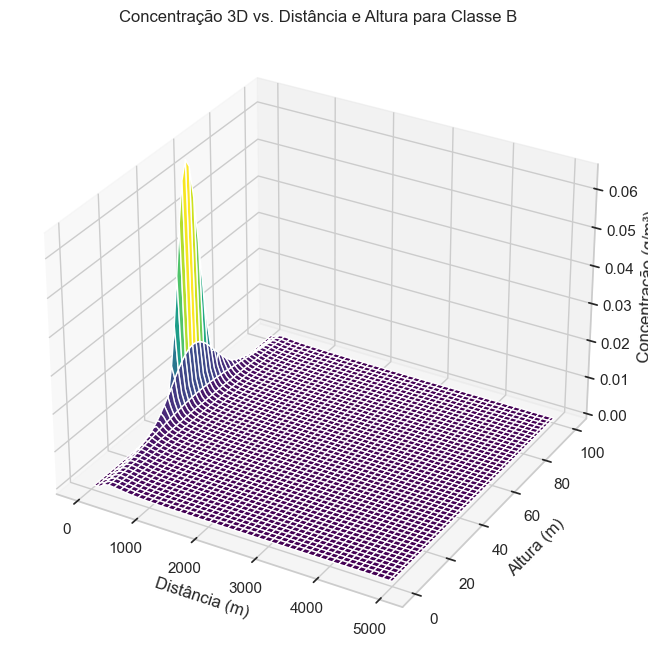

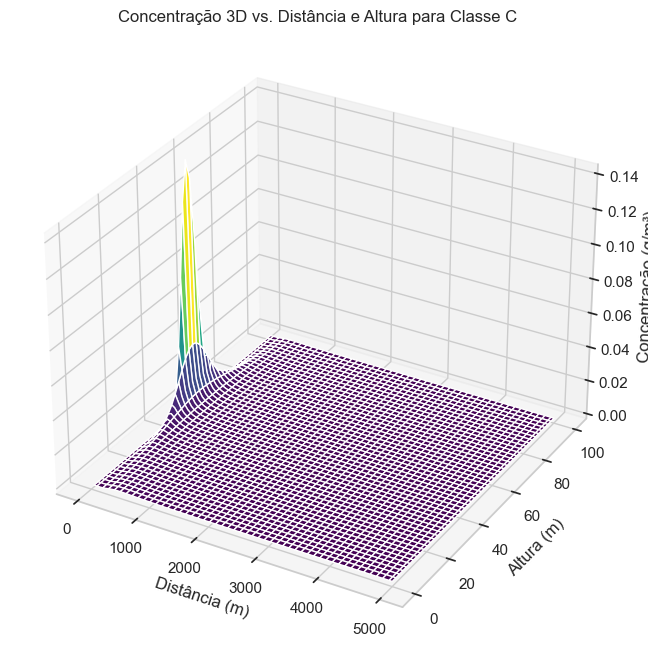

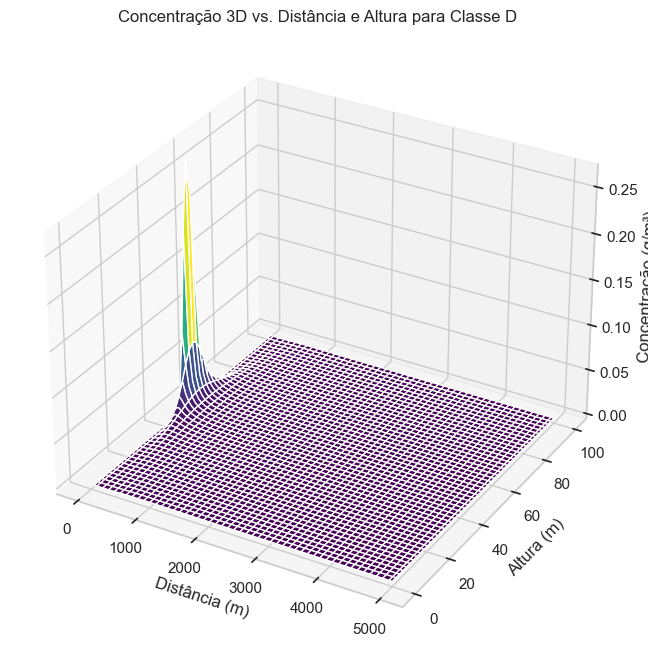

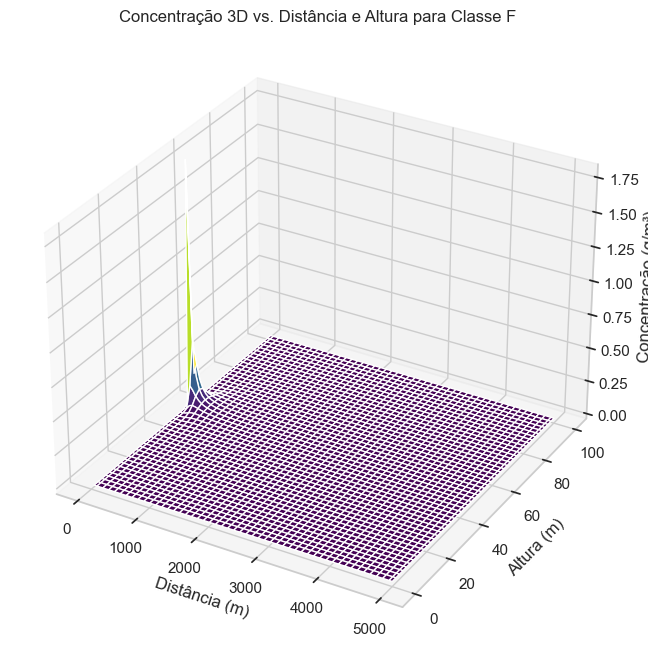

In [25]:
# Função para calcular concentração e plotar para uma classe de estabilidade específica
def plotar_concentracao_3d(classe_estabilidade, distancias, alturas, Q, u, H):
    X, Z = np.meshgrid(distancias, alturas)
    Y = np.zeros_like(X)
    delta_h = calcular_sobrelevação_pluma_briggs(Q, 10, u)  # Usando exemplo de D=10
    
    Sigma_y = np.array([calcular_sigma_y(d, classe_estabilidade) for d in distancias])
    Sigma_z = np.array([calcular_sigma_z(d, classe_estabilidade) for d in distancias])
    
    Concentracao = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Concentracao[i, j] = modelo_gaussiano(Q, u, X[i, j], Y[i, j], Z[i, j], H, Sigma_y[j], Sigma_z[j], delta_h)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Z, Concentracao, cmap='viridis')
    ax.set_title(f'Concentração 3D vs. Distância e Altura para Classe {classe_estabilidade}')
    ax.set_xlabel('Distância (m)')
    ax.set_ylabel('Altura (m)')
    ax.set_zlabel('Concentração (g/m³)')
    plt.show()

# Parâmetros de exemplo
Q = 100
u = 5  # Média da velocidade do vento para exemplo
H = 25

# Plotando para a classe de estabilidade 'A'
classe_exemplo_C = 'A'
distancias = np.linspace(0, 5000, 100)
alturas = np.linspace(0, 100, 50)
plotar_concentracao_3d(classe_exemplo_C, distancias, alturas, Q, u, H)

# Função para calcular concentração e plotar para uma classe de estabilidade específica
def plotar_concentracao_3d(classe_estabilidade, distancias, alturas, Q, u, H):
    X, Z = np.meshgrid(distancias, alturas)
    Y = np.zeros_like(X)
    delta_h = calcular_sobrelevação_pluma_briggs(Q, 10, u)  # Usando exemplo de D=10
    
    Sigma_y = np.array([calcular_sigma_y(d, classe_estabilidade) for d in distancias])
    Sigma_z = np.array([calcular_sigma_z(d, classe_estabilidade) for d in distancias])
    
    Concentracao = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Concentracao[i, j] = modelo_gaussiano(Q, u, X[i, j], Y[i, j], Z[i, j], H, Sigma_y[j], Sigma_z[j], delta_h)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Z, Concentracao, cmap='viridis')
    ax.set_title(f'Concentração 3D vs. Distância e Altura para Classe {classe_estabilidade}')
    ax.set_xlabel('Distância (m)')
    ax.set_ylabel('Altura (m)')
    ax.set_zlabel('Concentração (g/m³)')
    plt.show()

# Parâmetros de exemplo
Q = 100
u = 5  # Média da velocidade do vento para exemplo
H = 50

# Plotando para a classe de estabilidade 'B'
classe_exemplo_C = 'B'
distancias = np.linspace(0, 5000, 100)
alturas = np.linspace(0, 100, 50)
plotar_concentracao_3d(classe_exemplo_C, distancias, alturas, Q, u, H)

# Função para calcular concentração e plotar para uma classe de estabilidade específica
def plotar_concentracao_3d(classe_estabilidade, distancias, alturas, Q, u, H):
    X, Z = np.meshgrid(distancias, alturas)
    Y = np.zeros_like(X)
    delta_h = calcular_sobrelevação_pluma_briggs(Q, 10, u)  # Usando exemplo de D=10
    
    Sigma_y = np.array([calcular_sigma_y(d, classe_estabilidade) for d in distancias])
    Sigma_z = np.array([calcular_sigma_z(d, classe_estabilidade) for d in distancias])
    
    Concentracao = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Concentracao[i, j] = modelo_gaussiano(Q, u, X[i, j], Y[i, j], Z[i, j], H, Sigma_y[j], Sigma_z[j], delta_h)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Z, Concentracao, cmap='viridis')
    ax.set_title(f'Concentração 3D vs. Distância e Altura para Classe {classe_estabilidade}')
    ax.set_xlabel('Distância (m)')
    ax.set_ylabel('Altura (m)')
    ax.set_zlabel('Concentração (g/m³)')
    plt.show()

# Parâmetros de exemplo
Q = 100
u = 5  # Média da velocidade do vento para exemplo
H = 50

# Plotando para a classe de estabilidade 'C'
classe_exemplo_C = 'C'
distancias = np.linspace(0, 5000, 100)
alturas = np.linspace(0, 100, 50)
plotar_concentracao_3d(classe_exemplo_C, distancias, alturas, Q, u, H)

# Função para calcular concentração e plotar para uma classe de estabilidade específica
def plotar_concentracao_3d(classe_estabilidade, distancias, alturas, Q, u, H):
    X, Z = np.meshgrid(distancias, alturas)
    Y = np.zeros_like(X)
    delta_h = calcular_sobrelevação_pluma_briggs(Q, 10, u)  # Usando exemplo de D=10
    
    Sigma_y = np.array([calcular_sigma_y(d, classe_estabilidade) for d in distancias])
    Sigma_z = np.array([calcular_sigma_z(d, classe_estabilidade) for d in distancias])
    
    Concentracao = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Concentracao[i, j] = modelo_gaussiano(Q, u, X[i, j], Y[i, j], Z[i, j], H, Sigma_y[j], Sigma_z[j], delta_h)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Z, Concentracao, cmap='viridis')
    ax.set_title(f'Concentração 3D vs. Distância e Altura para Classe {classe_estabilidade}')
    ax.set_xlabel('Distância (m)')
    ax.set_ylabel('Altura (m)')
    ax.set_zlabel('Concentração (g/m³)')
    plt.show()

# Parâmetros de exemplo
Q = 100
u = 5  # Média da velocidade do vento para exemplo
H = 50

# Plotando para a classe de estabilidade 'D'
classe_exemplo_C = 'D'
distancias = np.linspace(0, 5000, 100)
alturas = np.linspace(0, 100, 50)
plotar_concentracao_3d(classe_exemplo_C, distancias, alturas, Q, u, H)

# Função para calcular concentração e plotar para uma classe de estabilidade específica
def plotar_concentracao_3d(classe_estabilidade, distancias, alturas, Q, u, H):
    X, Z = np.meshgrid(distancias, alturas)
    Y = np.zeros_like(X)
    delta_h = calcular_sobrelevação_pluma_briggs(Q, 10, u)  # Usando exemplo de D=10
    
    Sigma_y = np.array([calcular_sigma_y(d, classe_estabilidade) for d in distancias])
    Sigma_z = np.array([calcular_sigma_z(d, classe_estabilidade) for d in distancias])
    
    Concentracao = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Concentracao[i, j] = modelo_gaussiano(Q, u, X[i, j], Y[i, j], Z[i, j], H, Sigma_y[j], Sigma_z[j], delta_h)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Z, Concentracao, cmap='viridis')
    ax.set_title(f'Concentração 3D vs. Distância e Altura para Classe {classe_estabilidade}')
    ax.set_xlabel('Distância (m)')
    ax.set_ylabel('Altura (m)')
    ax.set_zlabel('Concentração (g/m³)')
    plt.show()

# Parâmetros de exemplo
Q = 100
u = 5  # Média da velocidade do vento para exemplo
H = 50

# Plotando para a classe de estabilidade 'F'
classe_exemplo_C = 'F'
distancias = np.linspace(0, 5000, 100)
alturas = np.linspace(0, 100, 50)
plotar_concentracao_3d(classe_exemplo_C, distancias, alturas, Q, u, H)

In [2]:
# Utilizando os dados de máxima da Votorantim - Vidal Ramos, para criar dois cenários
# Verificar se as concentrações estão de acordo com a CONAMA 491


Resultados Simulação 1
Classe de Estabilidade: A


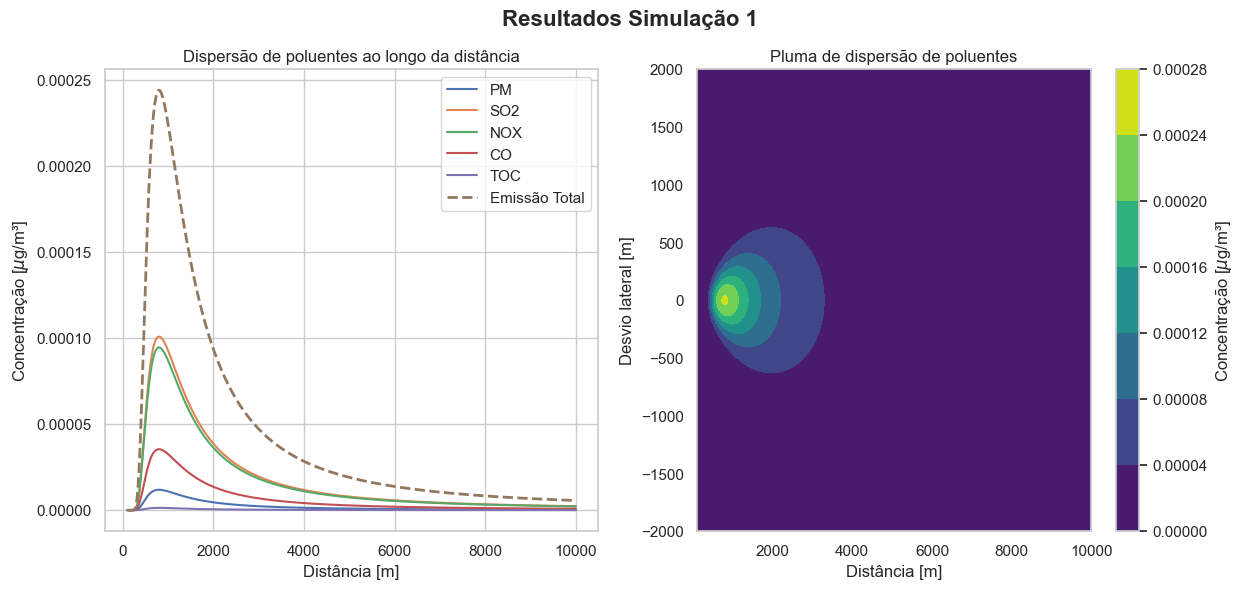


Resultados Simulação 2
Classe de Estabilidade: C


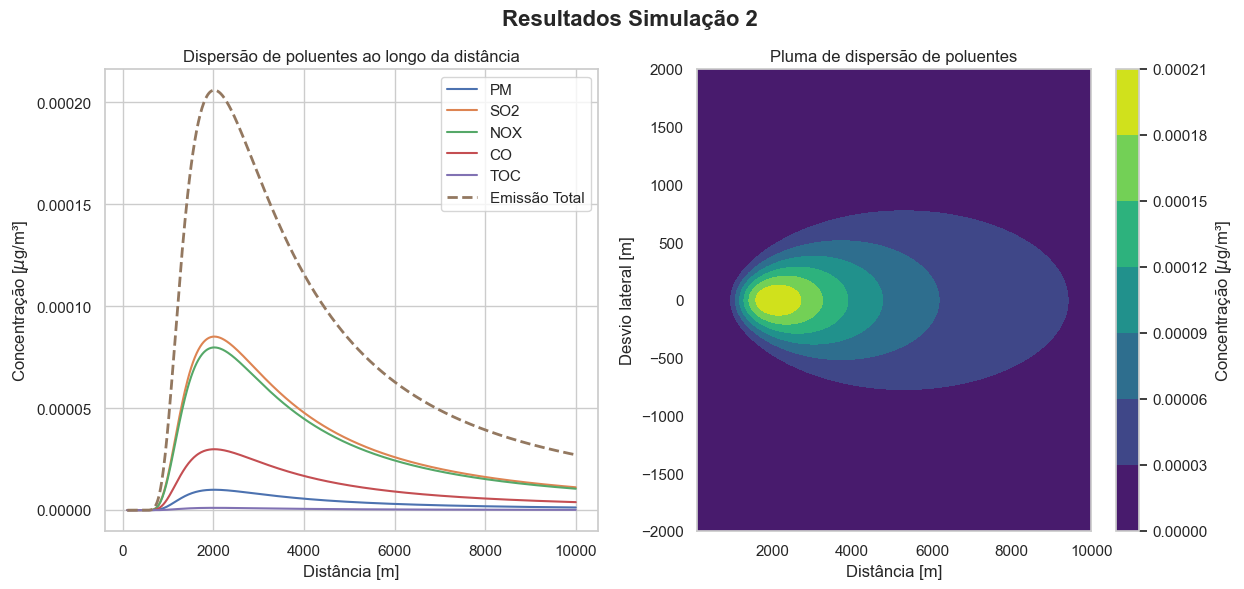


Resultados Simulação 3
Classe de Estabilidade: E


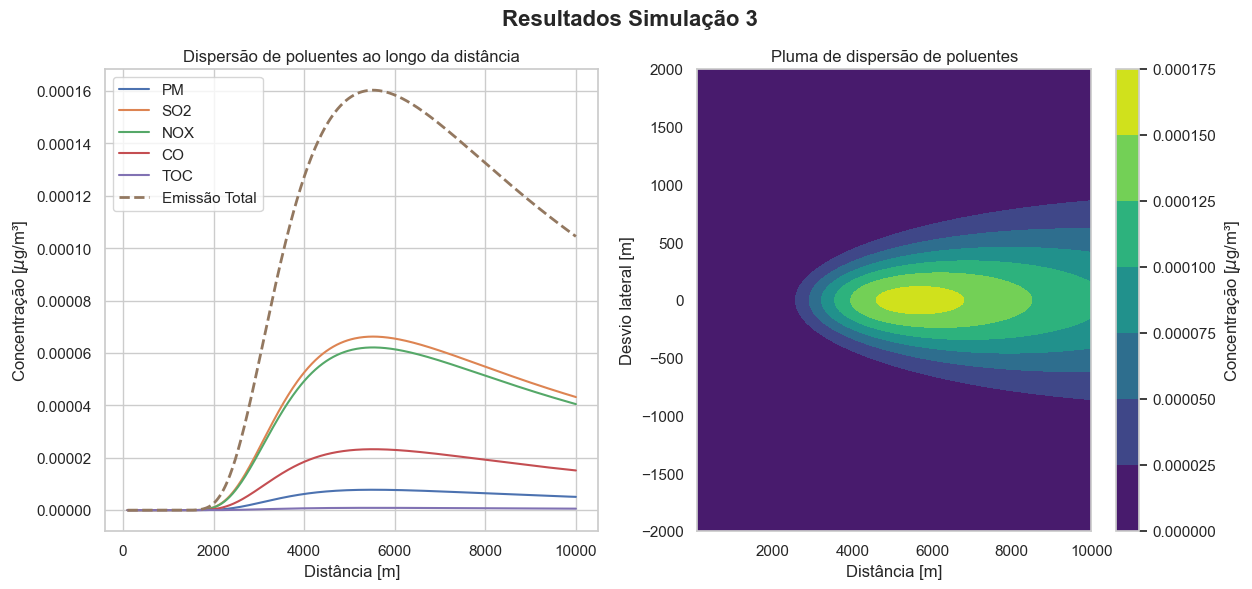

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dados de emissão dos poluentes
emissoes = {
    'PM': 19.308910,
    'SO2': 164.125736,
    'NOX': 153.867877,
    'CO': 57.625028,
    'TOC': 2.202423
}

# Parâmetros de entrada para as três simulações
simulacoes = [
    {
        'u': 5,  # m/s
        'y': 0,  # estimando na direção do vento
        'z': 1.5,  # altura do nariz
        'H': 25,  # altura da chaminé 
        'urbOrRural': 'urbano',
        'd': 2.5,  # Diâmetro da chaminé
        'Vs': 20,  # Velocidade de saída do gás
        'p': 1013,  # Pressão atmosférica em hPa
        'deltaT': 60,  # Diferença de temperatura entre a pluma e o ambiente
        'Ts': 533,  # Temperatura de saída da pluma
        'Fb': 1000,  # Fluxo de empuxo da pluma
        'x': np.linspace(100, 10000, 500)  # Distância
    },
    {
        'u': 5,  # m/s
        'y': 0,  # estimando na direção do vento
        'z': 1.5,  # altura do nariz
        'H': 25,  # altura da chaminé 
        'urbOrRural': 'urbano',
        'd': 2.5,  # Diâmetro da chaminé
        'Vs': 20,  # Velocidade de saída do gás
        'p': 1013,  # Pressão atmosférica em hPa
        'deltaT': 60,  # Diferença de temperatura entre a pluma e o ambiente
        'Ts': 533,  # Temperatura de saída da pluma
        'Fb': 1000,  # Fluxo de empuxo da pluma
        'x': np.linspace(100, 10000, 500)  # Distância
    },
    {
        'u': 5,  # m/s
        'y': 0,  # estimando na direção do vento
        'z': 1.5,  # altura do nariz
        'H': 25,  # altura da chaminé
        'urbOrRural': 'urbano',
        'd': 2.5,  # Diâmetro da chaminé
        'Vs': 20,  # Velocidade de saída do gás
        'p': 1013,  # Pressão atmosférica em hPa
        'deltaT': 60,  # Diferença de temperatura entre a pluma e o ambiente
        'Ts': 533,  # Temperatura de saída da pluma
        'Fb': 1000,  # Fluxo de empuxo da pluma
        'x': np.linspace(100, 10000, 500)  # Distância
    }
]

def sigmaYZ(x, classe, urbOrRural):
    # Função para calcular sigmaY e sigmaZ baseado na classe de estabilidade
    if classe == 'A':
        sigma_y = 0.22 * x * (1 + 0.0001 * x)**-0.5
        sigma_z = 0.20 * x
    elif classe == 'B':
        sigma_y = 0.16 * x * (1 + 0.0001 * x)**-0.5
        sigma_z = 0.12 * x
    elif classe == 'C':
        sigma_y = 0.11 * x * (1 + 0.0001 * x)**-0.5
        sigma_z = 0.08 * x
    elif classe == 'D':
        sigma_y = 0.08 * x * (1 + 0.0001 * x)**-0.5
        sigma_z = 0.06 * x
    elif classe == 'E':
        sigma_y = 0.06 * x * (1 + 0.0001 * x)**-0.5
        sigma_z = 0.03 * x
    elif classe == 'F':
        sigma_y = 0.04 * x * (1 + 0.0001 * x)**-0.5
        sigma_z = 0.016 * x
    else:
        raise ValueError(f"Classe de estabilidade desconhecida: {classe}")
    
    if urbOrRural == 'urbano':
        sigma_y *= 1.2
        sigma_z *= 1.2
        
    return sigma_y, sigma_z

def sobrelevacaoBriggs(Fb, Vs, d, u, deltaT, Ts, H, classe):
    # Função para calcular a sobrelevação da pluma usando a fórmula de Briggs
    deltaH = (1.6 * (Fb**0.333) * (d**0.666) * Vs) / (u * (deltaT / Ts)**0.333)
    return deltaH

def modeloGaussiano(qs, sigmaY, sigmaZ, u, y, z, H_eff):
    # Função para calcular a concentração usando o modelo gaussiano de dispersão
    return (qs / (2 * np.pi * u * sigmaY * sigmaZ)) * np.exp(-y**2 / (2 * sigmaY**2)) * (np.exp(-(z - H_eff)**2 / (2 * sigmaZ**2)) + np.exp(-(z + H_eff)**2 / (2 * sigmaZ**2)))

# Simulação para cada conjunto de parâmetros
for idx, params in enumerate(simulacoes):
    # Defina a classe de estabilidade para cada simulação
    if idx == 0:
        classe = 'A'
    elif idx == 1:
        classe = 'C'
    elif idx == 2:
        classe = 'E'
    else:
        raise ValueError("Número de simulações não suportado")
    
    # Imprime a classe de estabilidade
    print(f"\n{'='*40}\nResultados Simulação {idx+1}\n{'='*40}")
    print(f"Classe de Estabilidade: {classe}")
    
    sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
    deltaH = sobrelevacaoBriggs(params['Fb'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], params['H'], classe)
    H_eff = params['H'] + deltaH
    
    # Criar figura e eixos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'Resultados Simulação {idx+1}', fontsize=16, fontweight='bold')
    
    # Plotar gráfico de linha para cada poluente e a somatória
    for poluente, valor in emissoes.items():
        conc = modeloGaussiano(valor, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
        ax1.plot(params['x'], conc, label=f'{poluente}')
    
    # Plotar a somatória das emissões
    total_qs = sum(emissoes.values())
    conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc_total, label='Emissão Total', linestyle='--', linewidth=2)
    
    ax1.set_xlabel('Distância [m]')
    ax1.set_ylabel('Concentração [$\mu$g/m³]')
    ax1.set_title('Dispersão de poluentes ao longo da distância')
    ax1.legend()
    
    # Gráfico de contorno para a somatória das emissões
    X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
    sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
    conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)
    
    contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
    fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
    ax2.set_xlabel('Distância [m]')
    ax2.set_ylabel('Desvio lateral [m]')
    ax2.set_title('Pluma de dispersão de poluentes')
    
    plt.show()
